# OCA FLAT Files Scan and Analysis

In [90]:
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

from pathlib import Path

from astropy.io import fits
from astropy.coordinates import EarthLocation, AltAz, get_sun
from astropy.time import Time

import numpy as np

import polars as pl

from rich.progress import Progress

## Config

In [64]:
base_dir = '~/data/fits'
telescopes = ['zb08', 'wk06', 'jk15']

tel = 'jk15'

observatory = EarthLocation.of_site('OCA')
all_flat_file = Path(f"{tel}_all_flat_file_stats.parquet")


Directories

In [14]:
flats_dir = Path(base_dir).expanduser() / Path(tel) / Path('processed-ofp/flats')


In [18]:
filters = [f.name for f in flats_dir.glob('*')]
print('Recognized filters:', filters)

Recognized filters: ['empty', 'i', 'z', 'Ha_w', 'u_s', 'Ic', 'b_s', 'B', 'V', 'g', 'v_s', 'y_s', 'r', 'u']


In [59]:
stats_df = pl.DataFrame(schema={
    "filter": pl.Utf8,
    "file": pl.Utf8,
    "exptime": pl.Float64,
    "date-obs": pl.Datetime,
    "sun-alt": pl.Float64,
    "mean": pl.Float64,
    "median": pl.Float64,
    "std": pl.Float64,
    "min": pl.Float64,
    "max": pl.Float64,
    "min-05": pl.Float64,
    "max-95": pl.Float64,
    "mean-central-90": pl.Float64,
    "read-mod": pl.Int64,
    "gain-mod": pl.Int64,
    "flat-era": pl.Int64,
    "test": pl.Int64,
    "bitpix": pl.Int64,
})

with Progress() as progress:
    filter_task = progress.add_task("[cyan]Filter...", total=len(filters))
    for f in filters:
        # individual raw fits for ADU/s
        paths = list((flats_dir / Path(f)).glob(f'*/{tel}?_????_?????.fits'))
        file_task = progress.add_task(f"[green]FLATS of {f}...", total=len(paths))
        for p in paths:
            with fits.open(p) as hdul:
                hdu = hdul[0]
                date_obs = Time(hdu.header['DATE-OBS'], format='isot', scale='utc')
                altaz_frame = AltAz(obstime=date_obs, location=observatory)
                lower, upper = np.percentile(hdu.data, [5, 95])

                row = pl.DataFrame([{
                    'filter': f,
                    'file': p.name,
                    'exptime': hdu.header['EXPTIME'],
                    'date-obs': date_obs.to_datetime(),
                    'sun-alt': get_sun(date_obs).transform_to(altaz_frame).alt.deg,
                    'mean': hdu.data.mean(),
                    'median': np.median(hdu.data),
                    'std': hdu.data.std(),
                    'min': float(hdu.data.min()),
                    'max': float(hdu.data.max()),
                    'min-05': float(lower),
                    'max-95': float(upper),
                    'mean-central-90': np.mean(hdu.data[(hdu.data > lower) & (hdu.data < upper)]),
                    'read-mod': hdu.header['READ-MOD'],
                    'gain-mod': hdu.header['GAIN-MOD'],
                    'flat-era': hdu.header.get('FLAT-ERA', 0),
                    'test': hdu.header.get('TEST', 0),
                    'bitpix': hdu.header['BITPIX'],
                }])
                stats_df = pl.concat([stats_df, row], how='vertical')
                progress.update(file_task, advance=1)
        progress.update(filter_task, advance=1)

Output()

In [66]:
stats_df.write_parquet(all_flat_file)
print(f'All flat files stats saved to {all_flat_file}, {len(stats_df)} records')

All flat files stats saved to jk15_all_flat_file_stats.parquet, 1225 records


In [69]:
stats_df = stats_df.with_columns(
    ((stats_df['mean-central-90'] - 0) / stats_df['exptime']).alias("speed")
)

In [115]:
import plotly.express as px

read_mode = 5

filtered_data = stats_df.filter(
    (stats_df['sun-alt'] >= -10) &
    (stats_df['sun-alt'] <= 2) &
    (stats_df['read-mod'] == read_mode)
)

morning_conditions = (filtered_data['date-obs'].dt.hour().is_between(3, 9, closed="both"))

morning_data = filtered_data.filter(morning_conditions).sort("sun-alt").to_dict()
evening_data = filtered_data.filter(~morning_conditions).sort("sun-alt").to_dict()


def plot_speed_vs_sun_alt(data, title):
    fig = px.line(
        data,
        x="sun-alt",
        y="speed",
        color="filter",
        line_group="filter",
        hover_data=["file", "exptime", "read-mod", "gain-mod", "date-obs"],
        title=title,
        labels={"sun-alt": "Sun Altitude (deg)", "speed": "ADU/s"},
        log_y=True  # Log scale
    )
    fig.show()

for decr, data in [("Morning", morning_data), ("Evening", evening_data)]:
    plot_speed_vs_sun_alt(data, f"ADU/s vs Sun Altitude ({decr}, read-mod={read_mode})")

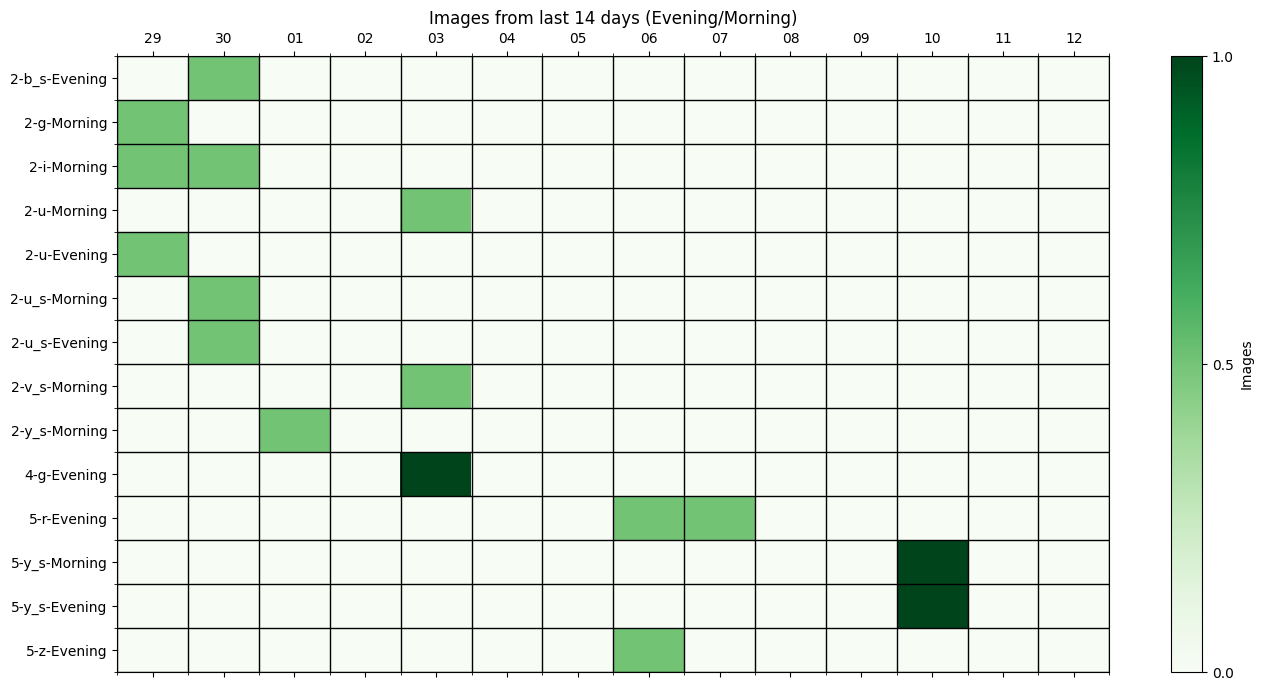

In [116]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta, timezone

# Time settings and parameters
threshold = 7
days_back = 14
end_date = datetime.now(timezone.utc).replace(tzinfo=None)
start_date = end_date - timedelta(days=days_back)

# Filter data for last 14 days
last_two_weeks = stats_df.filter(
    (pl.col("date-obs") >= start_date) &
    (pl.col("date-obs") <= end_date)
)

# Add columns for time of day and observation date
last_two_weeks = last_two_weeks.with_columns([
    (
            (pl.col("date-obs").dt.hour().is_between(21, 23)) |
            (pl.col("date-obs").dt.hour().is_between(0, 3))
    ).alias("evening"),
    pl.col("date-obs").dt.truncate("1d").alias("obs-date")
])

# Data aggregation
grouped_data = last_two_weeks.group_by(
    ["read-mod", "filter", "evening", "obs-date"]
).agg(
    pl.count("file").alias("counts")
)

# Prepare X and Y axes
x_labels = [(start_date + timedelta(days=i)).strftime('%d') for i in range(days_back)]
y_labels = [f"{row[0]}-{row[1]}-{'Evening' if row[2] else 'Morning'}"
            for row in grouped_data.select(["read-mod", "filter", "evening"]).unique().sort(
        by=["read-mod", "filter", "evening"]
    ).iter_rows()]

# Create plot matrix
heatmap_data = np.zeros((len(y_labels), len(x_labels)))

# Fill the matrix
for row in grouped_data.iter_rows():
    mod, filt, eve, date_obs, count = row
    y_idx = y_labels.index(f"{mod}-{filt}-{'Evening' if eve else 'Morning'}")
    x_idx = x_labels.index(date_obs.strftime('%d'))
    if count > threshold:
        heatmap_data[y_idx, x_idx] = 1  # Full fill
    elif count > 0:
        heatmap_data[y_idx, x_idx] = 0.5  # Dot
    else:
        heatmap_data[y_idx, x_idx] = 0  # Empty

# Plot creation
fig, ax = plt.subplots(figsize=(16, 8))
cax = ax.matshow(heatmap_data, cmap="Greens", aspect="auto")

# Add grid
ax.set_xticks(np.arange(-.5, len(x_labels), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(y_labels), 1), minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=1)

# Axis settings
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=0)

ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels(y_labels)

# Color bar
fig.colorbar(cax, ticks=[0, 0.5, 1], label="Images")
plt.title("Images from last 14 days (Evening/Morning)")
plt.show()

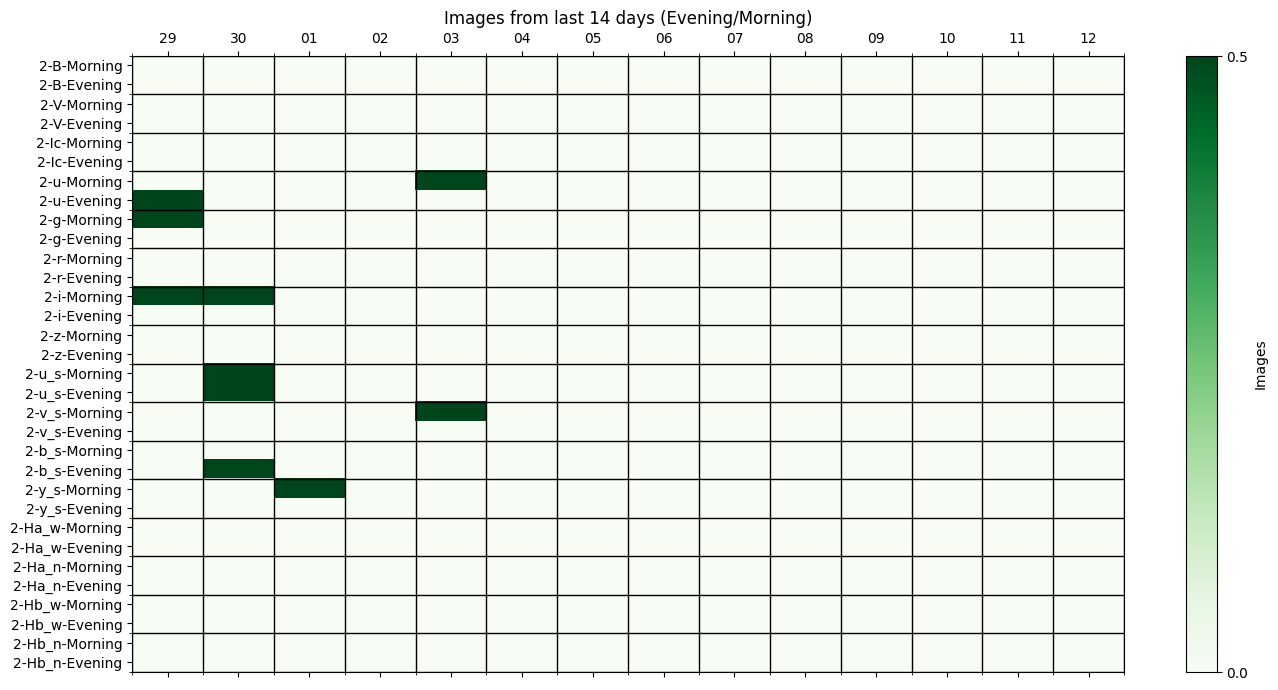

In [117]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta, timezone

# Time settings and parameters
threshold = 7
days_back = 14
end_date = datetime.now(timezone.utc).replace(tzinfo=None)
start_date = end_date - timedelta(days=days_back)

# Define standard sets of filters and read modes
show_read_modes = [2]
show_filters = [
    # Johnson-Cousins
    'B', 'V', 'Ic',
    # Sloan
    'u', 'g', 'r', 'i', 'z',
    # Strömgren
    'u_s', 'v_s', 'b_s', 'y_s',
    # Hydrogen lines
    'Ha_w', 'Ha_n', 'Hb_w', 'Hb_n'
]
time_periods = ['Morning', 'Evening']

# Create all combinations for y-axis (this ensures all combinations are shown)
y_labels = []
for mode in show_read_modes:
    for filt in show_filters:
        for period in time_periods:
            y_labels.append(f"{mode}-{filt}-{period}")

# Filter data for last 14 days
last_two_weeks = stats_df.filter(
    (pl.col("date-obs") >= start_date) &
    (pl.col("date-obs") <= end_date)
)

# Add columns for time of day and observation date
last_two_weeks = last_two_weeks.with_columns([
    (
            (pl.col("date-obs").dt.hour().is_between(21, 23)) |
            (pl.col("date-obs").dt.hour().is_between(0, 3))
    ).alias("evening"),
    pl.col("date-obs").dt.truncate("1d").alias("obs-date")
])

# Data aggregation
grouped_data = last_two_weeks.group_by(
    ["read-mod", "filter", "evening", "obs-date"]
).agg(
    pl.count("file").alias("counts")
)

# Prepare X axis
x_labels = [(start_date + timedelta(days=i)).strftime('%d') for i in range(days_back)]

# Create plot matrix
heatmap_data = np.zeros((len(y_labels), len(x_labels)))

# Fill the matrix
for row in grouped_data.iter_rows():
    mod, filt, eve, date_obs, count = row
    if mod in show_read_modes and filt in show_filters:
        label = f"{mod}-{filt}-{'Evening' if eve else 'Morning'}"
        if label in y_labels:  # Check if this combination is in our predefined set
            y_idx = y_labels.index(label)
            x_idx = x_labels.index(date_obs.strftime('%d'))
            if count > threshold:
                heatmap_data[y_idx, x_idx] = 1  # Full fill
            elif count > 0:
                heatmap_data[y_idx, x_idx] = 0.5  # Dot

# Plot creation
fig, ax = plt.subplots(figsize=(16, 8))
cax = ax.matshow(heatmap_data, cmap="Greens", aspect="auto")

# Add grid only between different filter+readmode sets (not between evening/morning)
grid_lines = np.arange(-.5, len(y_labels), 2)  # Skip every other line
ax.set_yticks(grid_lines, minor=True)
ax.set_xticks(np.arange(-.5, len(x_labels), 1), minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=1)

# Axis settings
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=0)

ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels(y_labels)

# Color bar
fig.colorbar(cax, ticks=[0, 0.5, 1], label="Images")
plt.title("Images from last 14 days (Evening/Morning)")
plt.show()